# load and inspect data

In [1]:
from data.fbirn_ica.load_data import load_data as load_fbirn
from data.cobre_ica.load_data import load_data as load_cobre
from data.bsnip_ica.load_data import load_data as load_bsnip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fbirn_datadict, fbirn_demo = load_fbirn()
cobre_datadict, cobre_demo = load_cobre()
bsnip_datadict, bsnip_demo = load_bsnip()
print(f"FBIRN data keys: {fbirn_datadict.keys()}")
print(f"COBRE data keys: {cobre_datadict.keys()}")
print(f"BSNIP data keys: {bsnip_datadict.keys()}")

FBIRN data keys: dict_keys(['data', 'diags', 'sexes', 'ages', 'age_bins'])
COBRE data keys: dict_keys(['data', 'diags'])
BSNIP data keys: dict_keys(['data', 'diags', 'sexes', 'meds', 'ages', 'age_bins'])


In [3]:
# load data as numpy
fbirn_tc = fbirn_datadict['data']
cobre_tc = cobre_datadict['data']
bsnip_tc = bsnip_datadict['data']

# load target labels as numpy
TARGET = 'diags'
fbirn_labels = fbirn_datadict[TARGET]
cobre_labels = cobre_datadict[TARGET]
bsnip_labels = bsnip_datadict[TARGET]
all_labels = np.hstack([fbirn_labels, cobre_labels, bsnip_labels])

if TARGET == 'diags':
    bsnip_filter = [True if lbl in [0, 1] else False for lbl in bsnip_labels]
    bsnip_tc = bsnip_tc[bsnip_filter]
    bsnip_labels = bsnip_labels[bsnip_filter]

# stack all time course data, pad with zeros to match shapes
max_len = max(fbirn_tc.shape[1], cobre_tc.shape[1], bsnip_tc.shape[1])
print(f"Max time course length: {max_len}")
def pad_tc(tc, target_len):
    if tc.shape[1] < target_len:
        pad_width = target_len - tc.shape[1]
        return np.pad(tc, ((0, 0), (0, pad_width), (0, 0)), mode='median')
    else:
        return tc[:, :target_len, :]
fbirn_tc_pad = pad_tc(fbirn_tc, max_len)
cobre_tc_pad = pad_tc(cobre_tc, max_len)
bsnip_tc_pad = pad_tc(bsnip_tc, max_len)
all_tc = np.vstack([fbirn_tc_pad, cobre_tc_pad, bsnip_tc_pad])

print(f"FBIRN data shape: {fbirn_tc.shape}, labels: {np.unique(fbirn_labels, return_counts=True)}")
print(f"COBRE data shape: {cobre_tc.shape}, labels: {np.unique(cobre_labels, return_counts=True)}")
print(f"BSNIP data shape: {bsnip_tc.shape}, labels: {np.unique(bsnip_labels, return_counts=True)}")
print(f"All data shape: {all_tc.shape}, labels: {np.unique(all_labels, return_counts=True)}")

Max time course length: 230
FBIRN data shape: (311, 140, 53), labels: (array([0, 1]), array([160, 151]))
COBRE data shape: (157, 140, 53), labels: (array([0, 1]), array([89, 68]))
BSNIP data shape: (587, 230, 53), labels: (array([0, 1]), array([338, 249]))
All data shape: (1055, 230, 53), labels: (array([0, 1, 2, 3]), array([587, 468, 222, 130]))


In [44]:
# compute FNC
def zscore_np(x, axis=0, eps=1e-8):
    """
    numpy-only z-score

    Parameters
    ----------
    x : array_like
        data to z-score
    axis : int or tuple of int
        Axis/axes along which to compute mean/std. (e.g., axis=1 for (B,T,D) time axis)

    Returns
    -------
    xz : ndarray
        Z-scored array (same shape as x).
    """
    x = np.asarray(x)
    mu = np.mean(x, axis=axis, keepdims=True)
    sd = np.std(x, axis=axis, keepdims=True)
    return (x - mu) / (sd + eps)


def corrcoef_batch(x, eps=1e-8):
    """
    Batched Pearson correlation over features for time-series data.

    Parameters
    ----------
    X : array_like, shape (B, T, D)
        Data to correlate, arranged as Batch x Time x (D)Features.

    Returns
    -------
    C : ndarray, shape (B, D, D)
        Pearson correlation matrices per batch item.
    """
    x = np.asarray(x)
    B, T, D = x.shape

    # z-score along time
    Z = zscore_np(x, axis=1, eps=eps)   # (B, T, D)

    # Correlation = (Z^T @ Z) / T for each batch element
    C = np.einsum('btd,bte->bde', Z, Z) / T             # (B, D, D)

    # Symmetrize & fix diagonals (nice-to-have for numeric drift)
    C = 0.5 * (C + C.transpose(0, 2, 1))
    batch_indices = np.arange(B)[:, None]
    diag_indices = np.arange(D)
    C[batch_indices, diag_indices, diag_indices] = 1.0

    return C

def corrcoef_batch_tril(x, eps=1e-8):
    C = corrcoef_batch(x, eps=eps)
    tril_indices = np.tril_indices(C.shape[1], k=-1)
    return C[:, tril_indices[0], tril_indices[1]]

# compute FNC matrices
fbirn_fnc_full = corrcoef_batch(fbirn_tc)
cobre_fnc_full = corrcoef_batch(cobre_tc)
bsnip_fnc_full = corrcoef_batch(bsnip_tc)
all_fnc_full = np.vstack([fbirn_fnc_full, cobre_fnc_full, bsnip_fnc_full])

# extract lower-triangular FNC features
lower_tri_indices = np.tril_indices(fbirn_fnc_full.shape[1], k=-1)
# fbirn_fnc = fbirn_fnc_full[:, lower_tri_indices[0], lower_tri_indices[1]]
# cobre_fnc = cobre_fnc_full[:, lower_tri_indices[0], lower_tri_indices[1]]
# bsnip_fnc = bsnip_fnc_full[:, lower_tri_indices[0], lower_tri_indices[1]]
fbirn_fnc = corrcoef_batch_tril(fbirn_tc)
cobre_fnc = corrcoef_batch_tril(cobre_tc)
bsnip_fnc = corrcoef_batch_tril(bsnip_tc)
all_fnc = np.vstack([fbirn_fnc, cobre_fnc, bsnip_fnc])
all_labels = np.hstack([fbirn_labels, cobre_labels, bsnip_labels])

print(f"FBIRN FNC shape: {fbirn_fnc.shape}")
print(f"COBRE FNC shape: {cobre_fnc.shape}")
print(f"BSNIP FNC shape: {bsnip_fnc.shape}")
print(f"All FNC shape: {all_fnc.shape}, labels: {all_labels.shape}, {np.unique(all_labels, return_counts=True)}")

FBIRN FNC shape: (311, 1378)
COBRE FNC shape: (157, 1378)
BSNIP FNC shape: (587, 1378)
All FNC shape: (1055, 1378), labels: (1055,), (array([0, 1]), array([587, 468]))


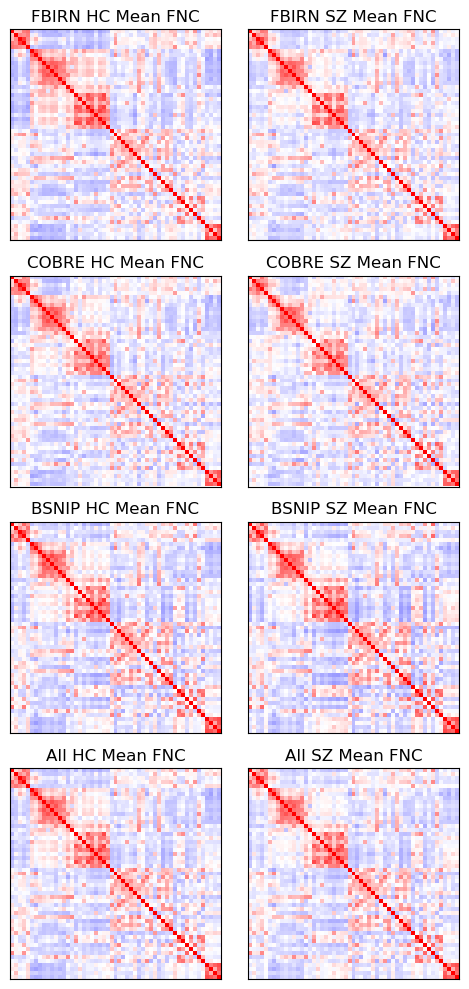

In [5]:
# visualize mean matrices
fbirn_0 = [True if lbl == 0 else False for lbl in fbirn_labels]
fbirn_1 = [True if lbl == 1 else False for lbl in fbirn_labels]
cobre_0 = [True if lbl == 0 else False for lbl in cobre_labels]
cobre_1 = [True if lbl == 1 else False for lbl in cobre_labels]
bsnip_0 = [True if lbl == 0 else False for lbl in bsnip_labels]
bsnip_1 = [True if lbl == 1 else False for lbl in bsnip_labels]

mean_fbirn_0 = np.mean(fbirn_fnc_full[fbirn_0], axis=0)
mean_fbirn_1 = np.mean(fbirn_fnc_full[fbirn_1], axis=0)
mean_cobre_0 = np.mean(cobre_fnc_full[cobre_0], axis=0)
mean_cobre_1 = np.mean(cobre_fnc_full[cobre_1], axis=0)
mean_bsnip_0 = np.mean(bsnip_fnc_full[bsnip_0], axis=0)
mean_bsnip_1 = np.mean(bsnip_fnc_full[bsnip_1], axis=0)

mean_all_0 = np.mean(np.concatenate([fbirn_fnc_full[fbirn_0], cobre_fnc_full[cobre_0], bsnip_fnc_full[bsnip_0]]), axis=0)
mean_all_1 = np.mean(np.concatenate([fbirn_fnc_full[fbirn_1], cobre_fnc_full[cobre_1], bsnip_fnc_full[bsnip_1]]), axis=0)


# plot mean matrices on a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(5, 10))
vmin, vmax = -1.0, 1.0
im0 = axes[0, 0].imshow(mean_fbirn_0, vmin=vmin, vmax=vmax, cmap='bwr')
axes[0, 0].set_title('FBIRN HC Mean FNC')
im1 = axes[0, 1].imshow(mean_fbirn_1, vmin=vmin, vmax=vmax, cmap='bwr')
axes[0, 1].set_title('FBIRN SZ Mean FNC')
im2 = axes[1, 0].imshow(mean_cobre_0, vmin=vmin, vmax=vmax, cmap='bwr')
axes[1, 0].set_title('COBRE HC Mean FNC')
im3 = axes[1, 1].imshow(mean_cobre_1, vmin=vmin, vmax=vmax, cmap='bwr')
axes[1, 1].set_title('COBRE SZ Mean FNC')
im4 = axes[2, 0].imshow(mean_bsnip_0, vmin=vmin, vmax=vmax, cmap='bwr')
axes[2, 0].set_title('BSNIP HC Mean FNC')
im5 = axes[2, 1].imshow(mean_bsnip_1, vmin=vmin, vmax=vmax, cmap='bwr')
axes[2, 1].set_title('BSNIP SZ Mean FNC')
im6 = axes[3, 0].imshow(mean_all_0, vmin=vmin, vmax=vmax, cmap='bwr')
axes[3, 0].set_title('All HC Mean FNC')
im7 = axes[3, 1].imshow(mean_all_1, vmin=vmin, vmax=vmax, cmap='bwr')
axes[3, 1].set_title('All SZ Mean FNC')
# hide all ticks
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

FBIRN HC TC shape: (22400, 53)
FBIRN SZ TC shape: (21140, 53)
COBRE HC TC shape: (12460, 53)
COBRE SZ TC shape: (9520, 53)
BSNIP HC TC shape: (77740, 53)
BSNIP SZ TC shape: (57270, 53)
All HC TC shape: (112600, 53)
All SZ TC shape: (87930, 53)


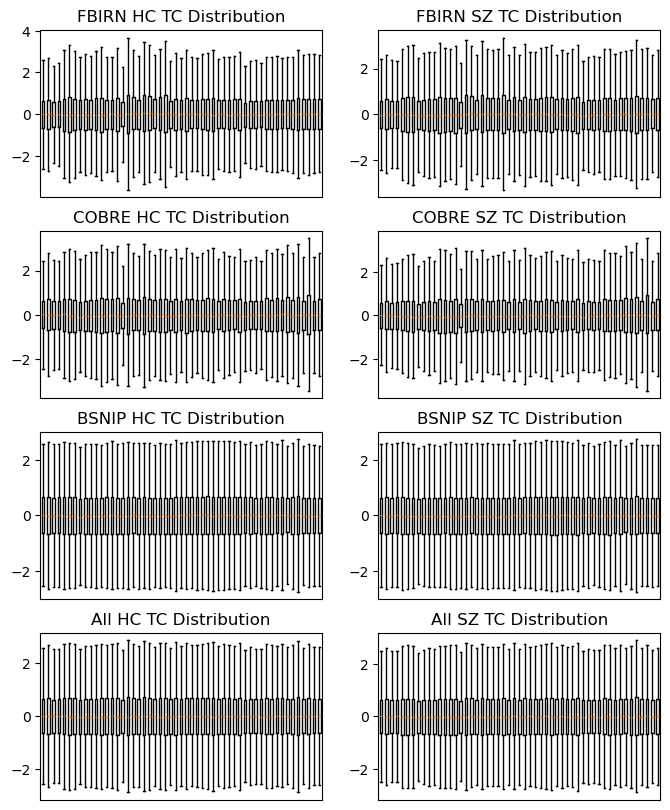

In [6]:
# visualize mean and variance of timecourses per feature as boxplots
fbirn_tc_0 = fbirn_tc[fbirn_0].reshape(sum(fbirn_0)*fbirn_tc.shape[1], -1)
fbirn_tc_1 = fbirn_tc[fbirn_1].reshape(sum(fbirn_1)*fbirn_tc.shape[1], -1)
cobre_tc_0 = cobre_tc[cobre_0].reshape(sum(cobre_0)*cobre_tc.shape[1], -1)
cobre_tc_1 = cobre_tc[cobre_1].reshape(sum(cobre_1)*cobre_tc.shape[1], -1)
bsnip_tc_0 = bsnip_tc[bsnip_0].reshape(sum(bsnip_0)*bsnip_tc.shape[1], -1)
bsnip_tc_1 = bsnip_tc[bsnip_1].reshape(sum(bsnip_1)*bsnip_tc.shape[1], -1)
all_tc_0 = np.concatenate([fbirn_tc_0, cobre_tc_0, bsnip_tc_0])
all_tc_1 = np.concatenate([fbirn_tc_1, cobre_tc_1, bsnip_tc_1])

for ds, lbls in zip([fbirn_tc_0, fbirn_tc_1, cobre_tc_0, cobre_tc_1, bsnip_tc_0, bsnip_tc_1, all_tc_0, all_tc_1],
                    ['FBIRN HC', 'FBIRN SZ', 'COBRE HC', 'COBRE SZ', 'BSNIP HC', 'BSNIP SZ', 'All HC', 'All SZ']):
    print(f"{lbls} TC shape: {ds.shape}")


# plot boxplots per channel on a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes[0, 0].boxplot(fbirn_tc_0, showfliers=False)
axes[0, 0].set_title('FBIRN HC TC Distribution')
axes[0, 1].boxplot(fbirn_tc_1, showfliers=False)
axes[0, 1].set_title('FBIRN SZ TC Distribution')
axes[1, 0].boxplot(cobre_tc_0, showfliers=False)
axes[1, 0].set_title('COBRE HC TC Distribution')
axes[1, 1].boxplot(cobre_tc_1, showfliers=False)
axes[1, 1].set_title('COBRE SZ TC Distribution')
axes[2, 0].boxplot(bsnip_tc_0, showfliers=False)
axes[2, 0].set_title('BSNIP HC TC Distribution')
axes[2, 1].boxplot(bsnip_tc_1, showfliers=False)
axes[2, 1].set_title('BSNIP SZ TC Distribution')
axes[3, 0].boxplot(all_tc_0, showfliers=False)
axes[3, 0].set_title('All HC TC Distribution')
axes[3, 1].boxplot(all_tc_1, showfliers=False)
axes[3, 1].set_title('All SZ TC Distribution')
# hide x ticks
for ax in axes.flat:
    ax.set_xticks([], [])

In [7]:
# prepare data dict
DATA_DICT = {
    'fbirn': {
        'tc': fbirn_tc.astype(np.float32),
        'fnc_full': fbirn_fnc_full.astype(np.float32),
        'fnc': fbirn_fnc.astype(np.float32),
        'labels': fbirn_labels.astype(np.int64)
    },
    'cobre': {
        'tc': cobre_tc.astype(np.float32),
        'fnc_full': cobre_fnc_full.astype(np.float32),
        'fnc': cobre_fnc.astype(np.float32),
        'labels': cobre_labels.astype(np.int64)
    },
    'bsnip': {
        'tc': bsnip_tc.astype(np.float32),
        'fnc_full': bsnip_fnc_full.astype(np.float32),
        'fnc': bsnip_fnc.astype(np.float32),
        'labels': bsnip_labels.astype(np.int64)
    },
    'all': {
        'tc': all_tc.astype(np.float32),
        'fnc_full': all_fnc_full.astype(np.float32),
        'fnc': all_fnc.astype(np.float32),
        'labels': all_labels.astype(np.int64)
    }
}

for k, v in DATA_DICT.items():
    print(f"{k} data shapes: tc {v['tc'].shape}, fnc_full {v['fnc_full'].shape}, fnc {v['fnc'].shape}, labels {v['labels'].shape}, label counts: {np.unique(v['labels'], return_counts=True)}")

fbirn data shapes: tc (311, 140, 53), fnc_full (311, 53, 53), fnc (311, 1378), labels (311,), label counts: (array([0, 1]), array([160, 151]))
cobre data shapes: tc (157, 140, 53), fnc_full (157, 53, 53), fnc (157, 1378), labels (157,), label counts: (array([0, 1]), array([89, 68]))
bsnip data shapes: tc (587, 230, 53), fnc_full (587, 53, 53), fnc (587, 1378), labels (587,), label counts: (array([0, 1]), array([338, 249]))
all data shapes: tc (1055, 230, 53), fnc_full (1055, 53, 53), fnc (1055, 1378), labels (1055,), label counts: (array([0, 1]), array([587, 468]))


# try ensembling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

def benchmark_on(data_key, clf, data_type='fnc', verbose=True):
    data = DATA_DICT[data_key]
    X = data[data_type]
    Y = data['labels']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # fit classifier
    clf.fit(X_train, y_train)

    # evaluate on test, compute classification report, accuracy and AUC
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    if verbose:
        print(f"Accuracy for {data_key}: {accuracy:0.3f}")
        print(f"AUC for {data_key}: {auc:0.3f}")
        # print(f"Classification report for {data_key}:\n{clf_report}")

    return auc, accuracy, clf_report


In [9]:
logs, reports = [], []

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
for key in DATA_DICT.keys():
    print(f"--- Benchmarking Random Forest on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='fnc')
    log = {'Data': key, 'Model': 'Random Forest', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking Random Forest on fbirn ---
Accuracy for fbirn: 0.714
AUC for fbirn: 0.772
--- Benchmarking Random Forest on cobre ---
Accuracy for cobre: 0.625
AUC for cobre: 0.714
--- Benchmarking Random Forest on bsnip ---
Accuracy for bsnip: 0.737
AUC for bsnip: 0.755
--- Benchmarking Random Forest on all ---
Accuracy for all: 0.654
AUC for all: 0.707


In [11]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=200, random_state=42)
for key in DATA_DICT.keys():
    print(f"--- Benchmarking Extra Trees on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='fnc')
    log = {'Data': key, 'Model': 'Extra Trees', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking Extra Trees on fbirn ---
Accuracy for fbirn: 0.683
AUC for fbirn: 0.809
--- Benchmarking Extra Trees on cobre ---
Accuracy for cobre: 0.562
AUC for cobre: 0.690
--- Benchmarking Extra Trees on bsnip ---
Accuracy for bsnip: 0.729
AUC for bsnip: 0.744
--- Benchmarking Extra Trees on all ---
Accuracy for all: 0.649
AUC for all: 0.732


In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
for key in DATA_DICT.keys():
    print(f"--- Benchmarking simple LR on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='fnc')
    log = {'Data': key, 'Model': 'LR', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking simple LR on fbirn ---
Accuracy for fbirn: 0.778
AUC for fbirn: 0.899
--- Benchmarking simple LR on cobre ---
Accuracy for cobre: 0.625
AUC for cobre: 0.671
--- Benchmarking simple LR on bsnip ---
Accuracy for bsnip: 0.644
AUC for bsnip: 0.717
--- Benchmarking simple LR on all ---
Accuracy for all: 0.716
AUC for all: 0.739


In [13]:
from sklearn.ensemble import BaggingClassifier


clf = BaggingClassifier(
    LogisticRegression(max_iter=1000),
    n_estimators=200,
    random_state=42,
    bootstrap=True,
    bootstrap_features=True,
    max_features=0.5
)
for key in DATA_DICT.keys():
    print(f"--- Benchmarking Bagged LR on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='fnc')
    log = {'Data': key, 'Model': 'Bagged LR', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking Bagged LR on fbirn ---
Accuracy for fbirn: 0.778
AUC for fbirn: 0.867
--- Benchmarking Bagged LR on cobre ---
Accuracy for cobre: 0.625
AUC for cobre: 0.649
--- Benchmarking Bagged LR on bsnip ---
Accuracy for bsnip: 0.686
AUC for bsnip: 0.754
--- Benchmarking Bagged LR on all ---
Accuracy for all: 0.716
AUC for all: 0.757


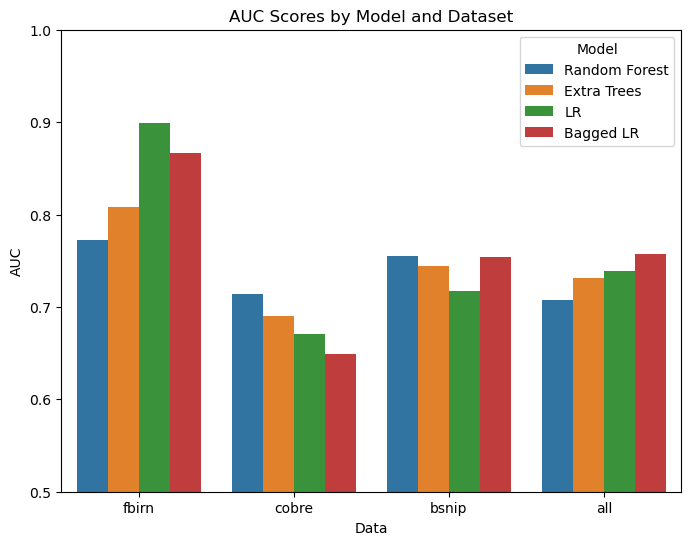

In [14]:
def plot_reports(logs):
    logs_df = pd.DataFrame(logs)
    # plot histogram of AUC scores per model for each dataset
    plt.figure(figsize=(8, 6))
    sns.barplot(data=logs_df, x='Data', y='AUC', hue='Model')
    plt.ylim(0.5, 1.0)
    plt.title('AUC Scores by Model and Dataset')
    plt.show()

plot_reports(logs)

# try ensembpling with meanMLP

In [15]:
# meanMLP

import torch
from torch import nn

class meanMLP(nn.Module):
    def __init__(
            self,
            input_size: int = 53,
            output_size: int = 2,
            hidden_size: int = 160,
            dropout: float = 0.49,
    ):

        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size, output_size),
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor):
        ts_logits = self.mlp(x)
        logits = ts_logits.mean(1)
        return logits
    
        probas = self.softmax(logits)

        return probas

CRITERION = nn.CrossEntropyLoss()


In [16]:
# dummy dataset
from sklearn.datasets import make_classification
all_X, all_y = make_classification(10000, 53, n_informative=10, random_state=0)
all_X = all_X.astype(np.float32)
all_y = all_y.astype(np.int64)
X = []
y = []
for yy in np.unique(all_y):
    X_class = all_X[all_y == yy]
    n_samples = X_class.shape[0] // 100
    X_class = X_class[:n_samples * 100].reshape(n_samples, 100, -1)
    y_class = np.array([yy] * n_samples, dtype=np.int64)
    X.append(X_class)
    y.append(y_class)
    print(f"Class {yy} shape: {X_class.shape}")
X = np.vstack(X)
y = np.hstack(y)
print(f"All X shape: {X.shape}, y shape: {y.shape}")

# test
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    meanMLP,
    max_epochs=100,
    lr=0.005,
    criterion=CRITERION,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)

y_proba = net.predict_proba(X)

Class 0 shape: (49, 100, 53)
Class 1 shape: (50, 100, 53)
All X shape: (99, 100, 53), y shape: (99,)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6774       0.6500        0.6871  0.0563
      2        0.6853       0.6500        0.6850  0.0098
      3        0.6765       0.6500        0.6831  0.0113
      4        0.6805       0.6500        0.6810  0.0116
      5        0.6698       0.7000        0.6790  0.0107
      6        0.6741       0.7000        0.6771  0.0109
      7        0.6693       0.7000        0.6751  0.0113
      8        0.6670       0.7500        0.6731  0.0102
      9        0.6631       0.8000        0.6712  0.0112
     10        0.6630       0.8500        0.6693  0.0109
     11        0.6596       0.8500        0.6674  0.0111
     12        0.6612       0.9000        0.6655  0.0115
     13        0.6573       0.9000        0.6636  0.0110
     14        0.6552       0.9500        0.

In [35]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from torch.optim import Adam

clf = NeuralNetClassifier(
    meanMLP,
    max_epochs=200,
    lr=0.005,
    criterion=CRITERION,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=50)],
    optimizer=Adam,
    batch_size=64,
    device='mps',
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=0
)

for key in DATA_DICT.keys():
    print(f"--- Benchmarking meanMLP on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='tc')
    log = {'Data': key, 'Model': 'meanMLP', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking meanMLP on fbirn ---
Accuracy for fbirn: 0.825
AUC for fbirn: 0.865
--- Benchmarking meanMLP on cobre ---
Accuracy for cobre: 0.562
AUC for cobre: 0.758
--- Benchmarking meanMLP on bsnip ---
Accuracy for bsnip: 0.686
AUC for bsnip: 0.778
--- Benchmarking meanMLP on all ---
Accuracy for all: 0.654
AUC for all: 0.675


In [ ]:
# custom bagging
import numpy as np
import torch
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class Bagging3DClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=10, max_features=1.0,
                 bootstrap=True, bootstrap_features=False, random_state=None, verbose=0):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_features = max_features          # float in (0,1] or int
        self.bootstrap = bootstrap                # resample rows with replacement
        self.bootstrap_features = bootstrap_features  # if False and nF<F -> without replacement
        self.random_state = random_state
        self.verbose = verbose

    def _rng(self, i=0):
        return np.random.RandomState(None if self.random_state is None else self.random_state + i)

    def _as_numpy(self, X):
        if torch.is_tensor(X):
            return X.detach().cpu().numpy()
        return np.asarray(X)

    def fit(self, X, y):
        X = self._as_numpy(X)   # expect (N, T, F)
        y = np.asarray(y)
        assert X.ndim == 3, f"Expected (N,T,F), got {X.shape}"
        N, T, F = X.shape

        # how many features per estimator
        nF = int(self.max_features * F) if isinstance(self.max_features, float) else int(self.max_features)
        nF = max(1, min(F, nF))

        self.estimators_, self.feature_indices_, self.sample_indices_ = [], [], []

        for i in range(self.n_estimators):
            rng = self._rng(i)

            # sample rows (with/without replacement)
            rows = rng.randint(0, N, size=N) if self.bootstrap else np.arange(N)

            # sample features along the last dim; replacement iff bootstrap_features
            if nF < F:
                feats = rng.choice(F, size=nF, replace=self.bootstrap_features)
            else:
                feats = np.arange(F)

            X_i = X[rows, :, :][:, :, feats]
            y_i = y[rows]

            est = clone(self.base_estimator)
            # the module's input size must match the selected features
            est.set_params(module__input_size=X_i.shape[-1])
            est.fit(X_i, y_i)

            self.estimators_.append(est)
            self.feature_indices_.append(feats)
            self.sample_indices_.append(rows)

        return self

    def predict_proba(self, X):
        X = self._as_numpy(X)
        assert X.ndim == 3
        probs = None
        for est, feats in zip(self.estimators_, self.feature_indices_):
            p = est.predict_proba(X[:, :, feats])
            probs = p if probs is None else probs + p
        return probs / len(self.estimators_)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [50]:
# meanMLP bagging
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from torch.optim import Adam

net = NeuralNetClassifier(
    meanMLP,
    max_epochs=200,
    lr=0.005,
    criterion=CRITERION,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=50)],
    optimizer=Adam,
    batch_size=64,
    device='mps',
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=0
)
clf = Bagging3DClassifier(
    base_estimator=net,
    n_estimators=20,
    bootstrap=True,               # rows with replacement
    bootstrap_features=True,      # features with replacement
    max_features=0.5,             # 50% of last-dim features per estimator
    random_state=42,
)

for key in DATA_DICT.keys():
    print(f"--- Benchmarking meanMLP on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, clf, data_type='tc')
    log = {'Data': key, 'Model': 'Bagged meanMLP', 'AUC': auc, 'Accuracy': accuracy}
    logs.append(log)
    reports.append(clf_report)

--- Benchmarking meanMLP on fbirn ---
Accuracy for fbirn: 0.730
AUC for fbirn: 0.855
--- Benchmarking meanMLP on cobre ---
Accuracy for cobre: 0.625
AUC for cobre: 0.680
--- Benchmarking meanMLP on bsnip ---
Accuracy for bsnip: 0.720
AUC for bsnip: 0.786
--- Benchmarking meanMLP on all ---
Accuracy for all: 0.692
AUC for all: 0.740


In [48]:
# voting
def tc_to_fnc(X):
    # Accept torch or numpy; return numpy (N, K)
    if torch.is_tensor(X):
        X = X.detach().cpu().numpy()
    if X.ndim == 3:
        return corrcoef_batch_tril(X)  # from your function
    elif X.ndim == 2:
        return X  # already fnc
    else:
        raise ValueError(f"Expected (N,T,F) or (N,K), got {X.shape}")

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

lr_pipe = make_pipeline(
    FunctionTransformer(tc_to_fnc, validate=False),
    LogisticRegression(max_iter=1000)
)

net = NeuralNetClassifier(
    meanMLP,
    max_epochs=200,
    lr=0.005,
    criterion=CRITERION,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=50)],
    optimizer=Adam,
    batch_size=64,
    device='mps',
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=0
)

from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(
    estimators=[('net', net), ('lr', lr_pipe)],
    voting='soft',           # average predicted probabilities
    weights=None             # or e.g. [2.0, 1.0] to favor the net
)

for key in DATA_DICT.keys():
    print(f"--- Voting (meanMLP + LR) on {key} ---")
    auc, accuracy, clf_report = benchmark_on(key, voter, data_type='tc')
    logs.append({'Data': key, 'Model': 'Voting(meanMLP,LR)', 'AUC': auc, 'Accuracy': accuracy})
    reports.append(clf_report)


--- Voting (meanMLP + LR) on fbirn ---
Accuracy for fbirn: 0.794
AUC for fbirn: 0.891
--- Voting (meanMLP + LR) on cobre ---
Accuracy for cobre: 0.688
AUC for cobre: 0.693
--- Voting (meanMLP + LR) on bsnip ---
Accuracy for bsnip: 0.703
AUC for bsnip: 0.766
--- Voting (meanMLP + LR) on all ---
Accuracy for all: 0.668
AUC for all: 0.738


In [28]:
logs = logs[:-4]
reports = reports[:-4]
len(logs), len(reports)

(16, 16)

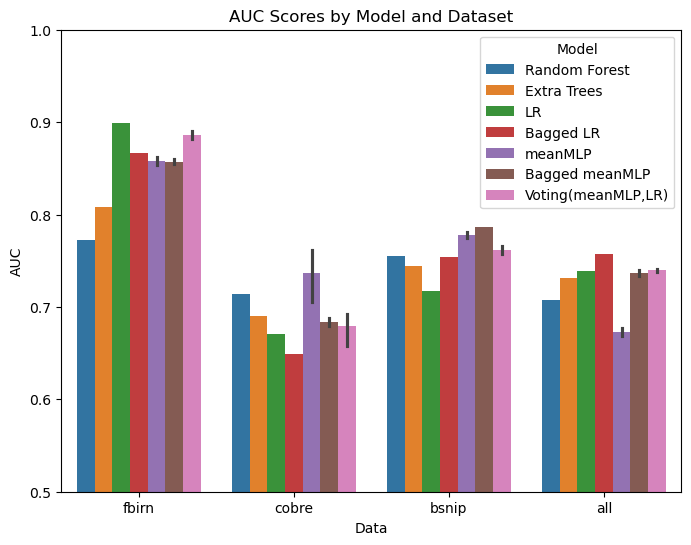

In [51]:
plot_reports(logs)